# 1. Reading Data & Preprocessing

In [ ]:
import glob
import os
import random
import pandas as pd
import numpy as np 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.layers import Dense
from keras import models
from keras import optimizers
import itertools
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
os.chdir("/scratch/rk9cx/conn_log_labelled_runtime/new_labelled_final/")

In [2]:
#random sampling
filename = "merged.csv"
n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 1000000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list

In [3]:
#preprocessing data
df = pd.read_csv(filename, skiprows=skip)
df = df.drop(df.columns[0], axis=1)
df = pd.concat([df, df['history'].str.join('|').str.get_dummies()], axis = 1)
df = df.drop(["history","honeypot","blacklist","whitelist"], axis=1)
df = pd.concat([df, pd.get_dummies(df.conn_state.apply(pd.Series), prefix="", prefix_sep="")], axis = 1)
df = df.drop(["conn_state"], axis=1)
df = df.replace('-', 0)
df.head()

,ts,src_ip,src_port,dest_ip,dest_port,duration,src_bytes,dest_bytes,src_pkts,dest_pkts,...,RSTOS0,RSTR,RSTRH,S0,S1,S2,S3,SF,SH,SHR
0,1.547096e+09,58.65.218.108,53642,3.110.212.127,1433,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,1.547096e+09,194.28.115.245,47821,3.110.40.180,33890,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,1.547096e+09,3.110.228.134,60556,52.94.235.145,443,39.393427,1394,6136,13,17,...,0,0,0,0,0,0,0,0,0,0
3,1.547096e+09,122.228.19.79,17146,3.110.65.97,8081,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,1.547096e+09,185.143.221.105,55499,3.110.110.240,8933,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [7]:
#more cleaning
sample = df.drop(["ts","src_ip","src_port","dest_ip","dest_port","src_ip_ext"], axis=1)
sample["duration"] = sample["duration"].astype(float)
sample["duration"] = np.log((sample["duration"].astype('int'))+0.001)
sample["src_bytes"] = sample["src_bytes"].astype(float)
sample["src_bytes"] = np.log((sample["src_bytes"].astype('int'))+0.001)
sample["dest_bytes"] = sample["dest_bytes"].astype(float)
sample["dest_bytes"] = np.log((sample["dest_bytes"].astype('int'))+0.001)
sample["src_pkts"] = np.log((sample["src_pkts"].astype('int'))+0.001)
sample["dest_pkts"] = np.log((sample["dest_pkts"].astype('int'))+0.001)

# 2. Principal Component Analysis

In [ ]:
#Standard scaling 
scaler = StandardScaler()
pred_variables = sample.loc[:, sample.columns != 'label']
resp_variables = sample.loc[:, sample.columns == 'label']
pred_variables = scaler.fit_transform(pred_variables)

In [38]:
pca = PCA(n_components=2)
X = pred_variables
X_r = pca.fit_transform(X)
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))
#combining PCs and response variable
X_c = pd.DataFrame(data=X_r)
X_c['label'] = resp_variables.iloc[:,0].values
X_c.columns = ['PC1', 'PC2',"label"]

explained variance ratio (first two components): [0.36867861 0.07031476]


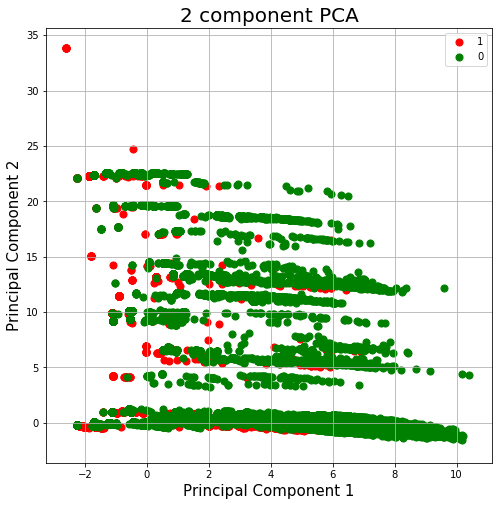

In [39]:
#Plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1,0]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = X_c.label == target
    ax.scatter(X_c.loc[indicesToKeep, 'PC1']
               , X_c.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# 3. Downsampling

In [39]:
mal = sample.loc[sample['label'] == 1].head(298226)
ben = sample.loc[sample['label'] == 0]
sampler = pd.concat([mal,ben], axis = 0)
sampler.label.value_counts(normalize = True)

0    0.500515
1    0.499485
Name: label, dtype: float64

In [12]:
X = sampler.loc[:, sampler.columns != 'label']
Y = sampler.loc[:, sampler.columns == 'label']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

# 4. Modelling

In [20]:
#function for plotting confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## 4.1 Logistic Regression

Confusion matrix, without normalization
[[85868 12879]
 [  272 97966]]


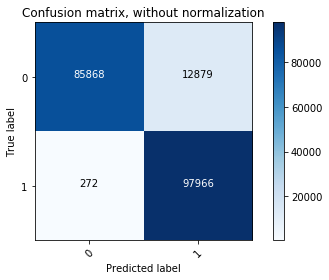

In [79]:
LR = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial').fit(X_train, y_train)
pred_y=LR.predict(X_test)
cm= confusion_matrix(y_test,pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [80]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.8838107266904236 0.9972312139905128 13.04242154192026 93.32385714648323


# 4.2 Random Forest

Confusion matrix, without normalization
[[85868   272]
 [12879 97966]]


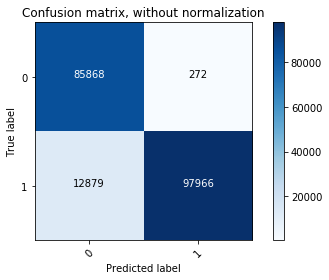

In [77]:
m = RandomForestClassifier(n_estimators=200, min_samples_leaf=100, max_features=0.5, n_jobs=-1)
m.fit(X_train, y_train)
pred_y = m.predict(X_test)
cm= confusion_matrix(y_test, pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [75]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.9972312139905128 0.8838107266904236 0.3157650336661249 93.32385714648323


# 5. Jeremy Howard's Methodology

In [6]:
from fastai.imports import *
from fastai.structured import *

## 5.1 Class Distribution - (Malicious/Benign) = (70/30)

In [5]:
rf_sample = df.drop(["src_ip_ext","src_ip"], axis=1)
rf_sample["duration"] = rf_sample["duration"].astype(float)
rf_sample["duration"] = np.log((rf_sample["duration"].astype('int'))+0.001)
rf_sample["src_bytes"] = rf_sample["src_bytes"].astype(float)
rf_sample["src_bytes"] = np.log((rf_sample["src_bytes"].astype('int'))+0.001)
rf_sample["dest_bytes"] = rf_sample["dest_bytes"].astype(float)
rf_sample["dest_bytes"] = np.log((rf_sample["dest_bytes"].astype('int'))+0.001)
rf_sample["src_pkts"] = np.log((rf_sample["src_pkts"].astype('int'))+0.001)
rf_sample["dest_pkts"] = np.log((rf_sample["dest_pkts"].astype('int'))+0.001)
rf_sample['ts'] = pd.to_datetime(rf_sample['ts'],unit='s')
rf_sample["src_port"] = rf_sample["src_port"].astype('category')
rf_sample["dest_ip"] = rf_sample["dest_ip"].astype('category')
rf_sample["dest_port"] = rf_sample["dest_port"].astype('category')
rf_sample["src_port"] = rf_sample["src_port"].cat.codes
rf_sample["dest_ip"] = rf_sample["dest_ip"].cat.codes
rf_sample["dest_port"] = rf_sample["dest_port"].cat.codes

In [11]:
#converting date into different fatures
add_datepart(rf_sample, 'ts')

In [13]:
X = rf_sample.loc[:, rf_sample.columns != 'label']
Y = rf_sample.loc[:, rf_sample.columns == 'label']

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [16]:
#subsetting train values for faster model execution
def split_vals(a,n): return a[:n].copy(), a[n:].copy()
X_train_sub, _ = split_vals(X_train, 50000)
y_train_sub, _ = split_vals(y_train, 50000)

Confusion matrix, without normalization
[[ 87496  10659]
 [  1081 230764]]


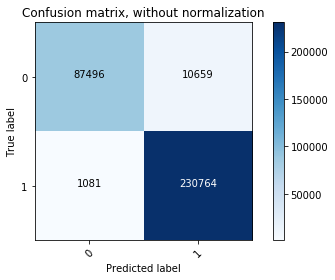

In [21]:
m = RandomForestClassifier(n_estimators=200, min_samples_leaf=100, max_features=0.5, n_jobs=-1)
m.fit(X_train_sub, y_train_sub) 
pred_y = m.predict(X_test)
cm= confusion_matrix(y_test, pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [22]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.9558492769951495 0.9953374021436736 10.859355101624981 96.44242424242424


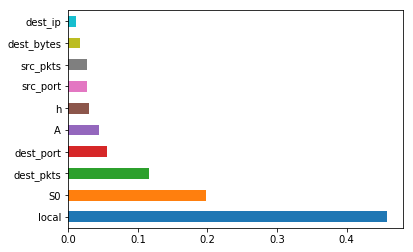

In [23]:
feat_importances = pd.Series(m.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

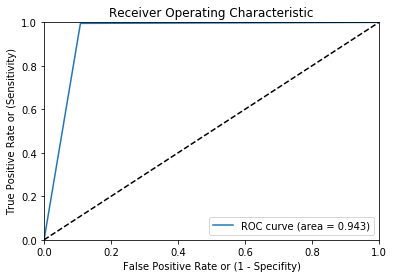

In [24]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, pred_y)
roc_auc = auc(fpr,tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## 5.2 Class Distribution - (Malicious/Benign) - (50/50)

In [28]:
mal = rf_sample.loc[rf_sample['label'] == 1].head(298226)
ben = rf_sample.loc[rf_sample['label'] == 0]
rf_sampler = pd.concat([mal,ben], axis = 0)
rf_sampler.label.value_counts(normalize = True)

1    0.500021
0    0.499979
Name: label, dtype: float64

In [29]:
X = rf_sampler.loc[:, rf_sample.columns != 'label']
Y = rf_sampler.loc[:, rf_sample.columns == 'label']

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [33]:
X_train_sub, _ = split_vals(X_train, 500000)
y_train_sub, _ = split_vals(y_train, 500000)

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Confusion matrix, without normalization
[[95103  3483]
 [  821 97414]]


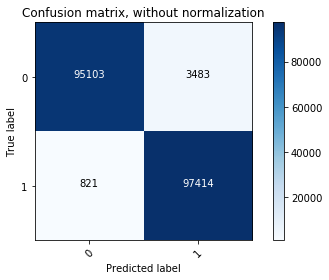

In [34]:
m = RandomForestClassifier(n_estimators=200, min_samples_leaf=100, max_features=0.5, n_jobs=-1)
m.fit(X_train_sub, y_train_sub) 
pred_y = m.predict(X_test)
cm= confusion_matrix(y_test, pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [35]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.9654796475613745 0.9916424899475746 3.5329559978090197 97.81324147321678


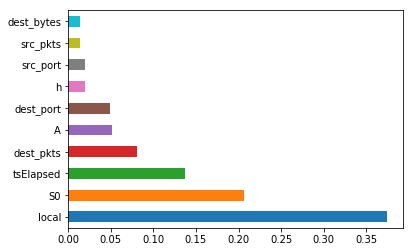

In [36]:
feat_importances = pd.Series(m.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

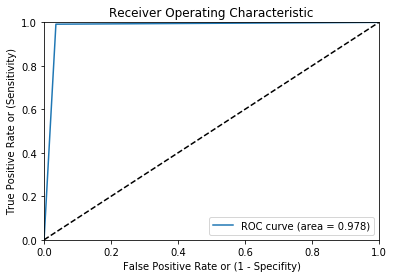

In [37]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, pred_y)
roc_auc = auc(fpr,tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## 5.3 Class Distribution - (Malicious/Benign) - (10/90)

In [38]:
mal = rf_sample.loc[rf_sample['label'] == 1].head(29822)
ben = rf_sample.loc[rf_sample['label'] == 0]
rf_sampler = pd.concat([mal,ben], axis = 0)
rf_sampler.label.value_counts(normalize = True)

0    0.909086
1    0.090914
Name: label, dtype: float64

In [39]:
X = rf_sampler.loc[:, rf_sample.columns != 'label']
Y = rf_sampler.loc[:, rf_sample.columns == 'label']

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [41]:
X_train_sub, _ = split_vals(X_train, 500000)
y_train_sub, _ = split_vals(y_train, 500000)

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Confusion matrix, without normalization
[[97885   555]
 [   18  9790]]


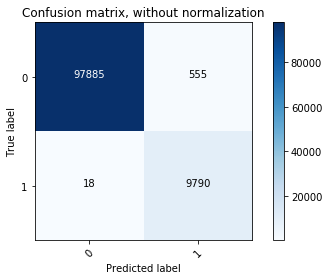

In [42]:
m = RandomForestClassifier(n_estimators=200, min_samples_leaf=100, max_features=0.5, n_jobs=-1)
m.fit(X_train_sub, y_train_sub) 
pred_y = m.predict(X_test)
cm= confusion_matrix(y_test, pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [43]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.9463508941517641 0.9981647634584013 0.5637952052011378 99.47065996600399


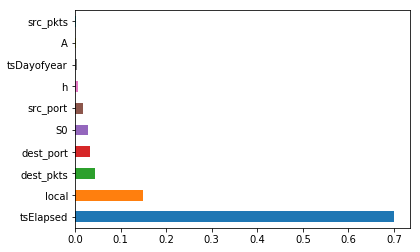

In [44]:
feat_importances = pd.Series(m.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

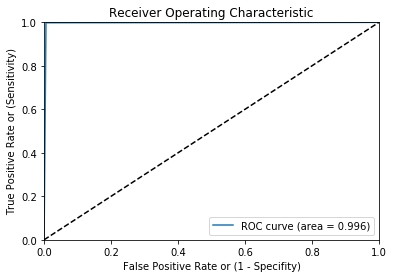

In [45]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, pred_y)
roc_auc = auc(fpr,tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")